## Importing libraries

In [60]:
# %matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import py21cmfast as p21c

## Cosmological Parameters (Default is used when no input is specified)

In [61]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [62]:
BOX_LEN=300  # Box length
DIM=600      # Number of Voxels for hight resolution 
HII_DIM=300  # Number of Voxels for low resolution 

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,
    DIM=DIM,
    HII_DIM=HII_DIM
)

## Creating initial conditions box

In [63]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params
)

## Cube Blurring Function

In [64]:
def Square_Blurring(box, radius, iteration):
    box = box.copy()  # make copy of input box to have a separate box
    for i in range(iteration):
        np.random.seed()  # set seed to a randome number
        
        rand_coord = np.random.randint(radius, BOX_LEN-1-radius, size=3)  # ensure that the random center point won't be at the edge of the cube
        
        cube_region = box[rand_coord[0]-radius:rand_coord[0]+radius+1, rand_coord[1]-radius:rand_coord[1]+radius+1, rand_coord[2]-radius:rand_coord[2]+radius+1]
        
        neutral_mean = np.mean(cube_region)
        
        box[rand_coord[0]-radius:rand_coord[0]+radius+1, rand_coord[1]-radius:rand_coord[1]+radius+1, rand_coord[2]-radius:rand_coord[2]+radius+1] = neutral_mean
    return box

## Gaussian function

In [65]:
def Gaussian(x, sigma=1, mu=0):
    return (1/sigma/np.sqrt(2*np.pi))*(np.exp(-0.5*(((x-mu)/sigma)**2)))

1.0


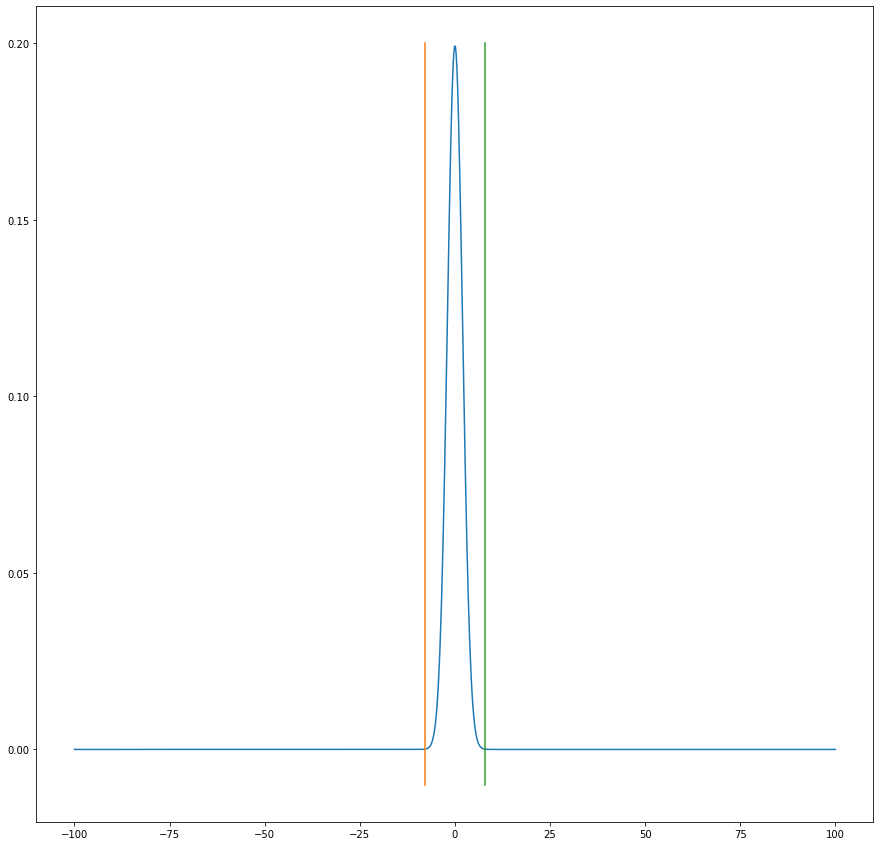

In [67]:
x = np.linspace(-100,100,10**3)
sigma = 2
g = Gaussian(x, sigma=sigma)
fig = plt.figure(figsize=(15,15))
plt.plot(x, g, [-4*sigma,-4*sigma], [-0.01, 0.2], [4*sigma,4*sigma], [-0.01, 0.2])

from scipy.integrate import simps

area = simps(g, x)
print(area)

## Random Coordinate

In [68]:
def random_voxel(box_shape):
    np.random.seed()  # set seed to a randome number
        
    coordinate = [np.random.randint(0, side_length) for side_length in box_shape]
    
    return coordinate

## Select a Smaller Cube with Sides 2R+1 Voxels, Centered about the Random Coordinate

In [69]:
def cube_centered_about_coordinate(coordinate_array, radius, box):
    x_ind1 = coordinate_array[0]-radius  # x-domian
    x_ind2 = coordinate_array[0]+radius+1  # ending index is not inclusive
    y_ind1 = coordinate_array[1]-radius  # y-domain
    y_ind2 = coordinate_array[1]+radius+1
    z_ind1 = coordinate_array[2]-radius  # z-domain
    z_ind2 = coordinate_array[2]+radius+1

    if x_ind1 < 0:  # periodic boundary conditions
        x_inds = np.r_[(x_ind1+box.shape[0]):box.shape[0], 0:x_ind2]
    elif x_ind2 > box.shape[0]:
        x_inds = np.r_[x_ind1:box.shape[0], 0:(x_ind2-box.shape[0])]
    else:
        x_inds = np.r_[x_ind1:x_ind2]

    if y_ind1 < 0:
        y_inds = np.r_[(y_ind1+box.shape[1]):box.shape[1], 0:y_ind2]
    elif y_ind2 > box.shape[1]:
        y_inds = np.r_[y_ind1:box.shape[1], 0:(y_ind2-box.shape[1])]
    else:
        y_inds = np.r_[y_ind1:y_ind2]

    if z_ind1 < 0:
        z_inds = np.r_[(z_ind1+box.shape[2]):box.shape[2], 0:z_ind2]
    elif z_ind2 > box.shape[2]:
        z_inds = np.r_[z_ind1:box.shape[2], 0:(z_ind2-box.shape[2])]
    else:
        z_inds = np.r_[z_ind1:z_ind2]

    indices = np.ix_(x_inds, y_inds, z_inds)
    
    cube = box[indices]
    
    return indices, cube

## Measure the distance of each voxel to the center

In [175]:
def distance_from_coordinate(box_shape):
    index_x = np.arange(-0.5*(box_shape[0]-1), 0.5*(box_shape[0]+1))
    index_y = np.arange(-0.5*(box_shape[1]-1), 0.5*(box_shape[1]+1))
    index_z = np.arange(-0.5*(box_shape[2]-1), 0.5*(box_shape[2]+1))

    x, y, z = np.meshgrid(index_x, index_y, index_z, indexing='ij')

    distance = np.sqrt((x)**2 + (y)**2 + (z)**2)
    
    return distance

## Average values of a shperical region in a given box,  with diameter = sides of box, sphere centered on cube's center

In [80]:
def top_hat_sphere_average_value(distance_box, radius, input_box):
    sphere_condition_box =  distance_box <= radius
    inside_sphere_mean = np.mean(input_box[sphere_condition_box])  # slicing shaped array by condition will ravel the array
    return inside_sphere_mean, sphere_condition_box

## Average 4 spherical shells in a given box,  with diameter = sides of box, sphere centered on cube's center

In [81]:
def top_hat_shell_averaging(distance_box, radius, input_box):
    
    sphere_condition =  distance_box <= radius
        
    inside_sphere_mean = np.mean(input_box[sphere_condition])  # slicing shaped array by condition will ravel the array

    shell_condition1 =  distance_box <= 0.25*radius
    shell_condition2 =  np.logical_and(distance_box <= 0.5*radius, distance_box > 0.25*radius)
    shell_condition3 =  np.logical_and(distance_box <= 0.75*radius, distance_box > 0.5*radius)
    shell_condition4 =  np.logical_and(distance_box <= radius, distance_box > 0.75*radius)
    
    output_box = np.where(shell_condition1, inside_sphere_mean, input_box)
    output_box = np.where(shell_condition2, 0.75*inside_sphere_mean, output_box)
    output_box = np.where(shell_condition3, 0.5*inside_sphere_mean, output_box)
    output_box = np.where(shell_condition4, 0.25*inside_sphere_mean, output_box)

    return output_box

## Gausssian Averaging

In [104]:
def gaussian_sphere_average_value(distance_box, radius, input_box):
    
    mean = []

    shell_radius_edges = np.linspace(0,1,5)
    shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])
    weight = Gaussian(x=shell_center*4)

    for ii in range(len(shell_radius_edges)-1):
        condition = np.logical_and(distance_box <= shell_radius_edges[ii+1]*radius, distance_box > shell_radius_edges[ii]*radius)
        inside_shell_mean = np.mean(input_box[condition])
        mean = np.append(mean, inside_shell_mean)

    Gaussian_mean = np.average(mean, weights=weight)
    
    return Gaussian_mean, distance_box <= radius

## Sphere Blurring Function

In [187]:
def Sphere_Blurring(box, radius, iteration):
    
    box = box.copy()  # make copy of input box to have a separate box
    
    dist_frm_coord_box = distance_from_coordinate([radius*2+1]*3)

    
    inside_sphere_mean_data_top_hat = []  # empty list for data collection
    inside_sphere_mean_data_gaussian = []
    
    for i in range(iteration):
        
        rand_coord = random_voxel(box.shape)
                
        box_indices, cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
        
        inside_sphere_mean_top_hat, sphere_condition_box = top_hat_sphere_average_value(dist_frm_coord_box, radius, cube_region_box)

        inside_sphere_mean_gaussian, sphere_condition_box = gaussian_sphere_average_value(dist_frm_coord_box, radius, cube_region_box)
        # returning sphere_condition_box only for plotting box purposes, could be removed if plotting the box is no longer required
        
        
        
#         inside_sphere_mean_data_top_hat = np.append(inside_sphere_mean_data_top_hat, inside_sphere_mean_top_hat)
#         inside_sphere_mean_data_gaussian = np.append(inside_sphere_mean_data_gaussian, inside_sphere_mean_gaussian)
#     return np.array(inside_sphere_mean_data_top_hat), np.array(inside_sphere_mean_data_gaussian)


        cube_region_box = np.where(sphere_condition_box, inside_sphere_mean_gaussian, cube_region_box)
        box[box_indices] = cube_region_box
    return box




## Function to Make the colorbar fit with the plot in the figures

In [106]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label="Neutral Fraction")
    plt.sca(last_axes)
    return cbar

## Histogram Function

In [173]:
def histogram(f1, f2, f3, x_start=0, x_stop=1, bin_num=100):  # a: x start, b: x stop
    bin_edges = np.linspace(x_start, x_stop, bin_num) # 100 bins from 0-1
    hist1, _ = np.histogram(f1, bins=bin_edges)
    hist2, _ = np.histogram(f2, bins=bin_edges)
    hist3, _ = np.histogram(f3, bins=bin_edges)

    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    fig, axes = plt.subplots(ncols=3, figsize=(15,5))
    axes[0].plot(bin_centers, hist1)
    axes[1].plot(bin_centers, hist2)
    axes[2].plot(bin_centers, hist3)
#     plt.title("Distribution", color='white')
#     plt.xlabel("Neutral Fraction", color='white')
    
    # Set the borders to a given color...
    for ax in axes:
        ax.tick_params(color='white', labelcolor='white')
        for spine in ax.spines.values():
            spine.set_edgecolor('white')

## Creating Ionize box

In [108]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

## Creating Noise Box

In [109]:
np.random.seed()
noise_box = np.random.rand(301,301,301)

## Blurring the box

In [199]:
Sphere_blurred = Sphere_Blurring(box=noise_box, radius=150, iteration=1)

# Periodic BCs

## Creating Histogram

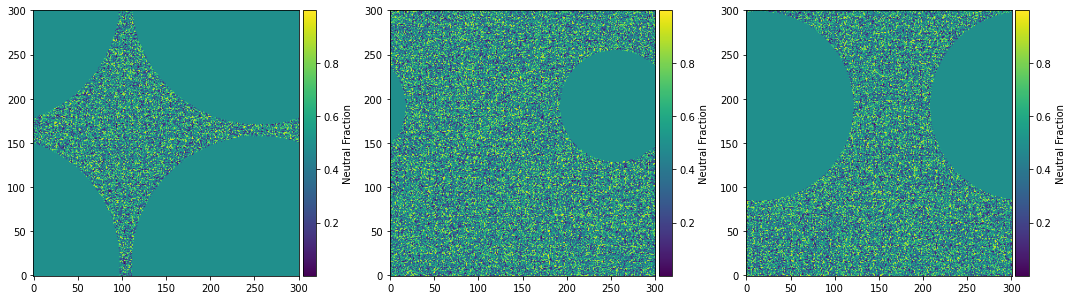

In [200]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,15))

img1 = ax1.imshow(Sphere_blurred[150,:,:], origin='lower')
colorbar(img1)

img2 = ax2.imshow(Sphere_blurred[:,150,:], origin='lower')
colorbar(img2)

img3 = ax3.imshow(Sphere_blurred[:,:,150], origin='lower')
colorbar(img3)

plt.tight_layout(h_pad=1)

# Distribution of average values of a noise box

# Shells

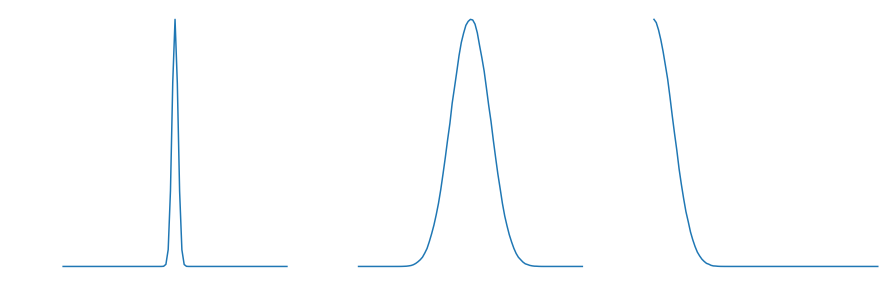

In [197]:
histogram(top_hat, gaussian, top_hat-gaussian)
# 10**6 iterations

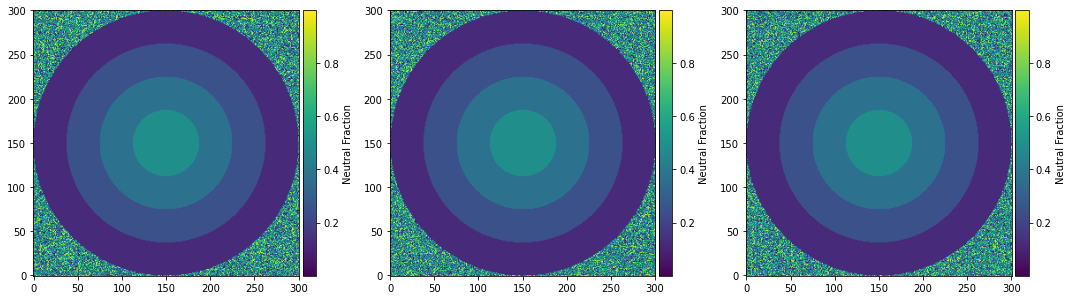

In [196]:
radius = 150
shell_box = top_hat_shell_averaging(distance_from_coordinate([radius*2+1]*3), radius, noise_box)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,15))

img1 = ax1.imshow(shell_box[150,:,:], origin='lower')
colorbar(img1)

img2 = ax2.imshow(shell_box[:,150,:], origin='lower')
colorbar(img2)

img3 = ax3.imshow(shell_box[:,:,150], origin='lower')
colorbar(img3)

plt.tight_layout(h_pad=1)

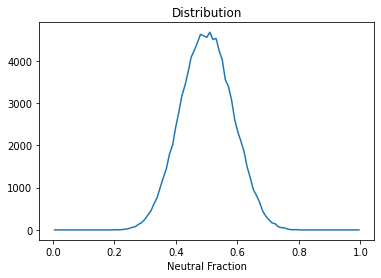

In [152]:
histogram(gaussian)
# 10**5 iterations

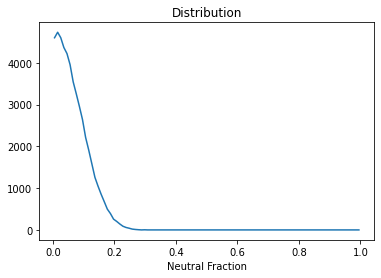

In [153]:
histogram(top_hat-gaussian)
# 10**5 iterations

## x, y, z slices of the blurred box

# Gaussian Blurr

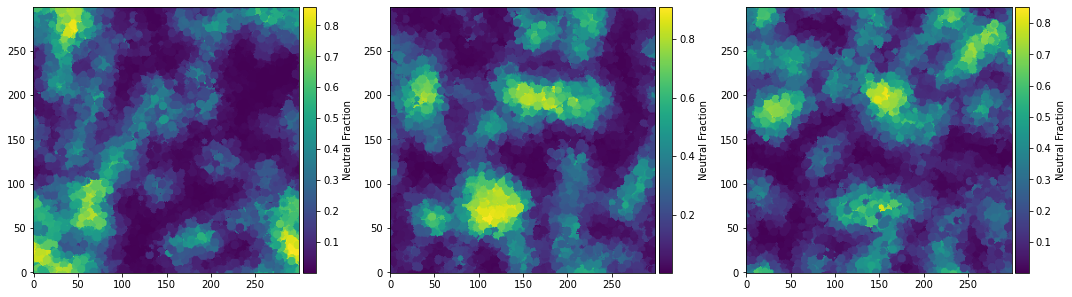

In [129]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,15))

img1 = ax1.imshow(Sphere_blurred[150,:,:], origin='lower')
colorbar(img1)

img2 = ax2.imshow(Sphere_blurred[:,150,:], origin='lower')
colorbar(img2)

img3 = ax3.imshow(Sphere_blurred[:,:,150], origin='lower')
colorbar(img3)

plt.tight_layout(h_pad=1)

## unblurred and blurred side by side comparison

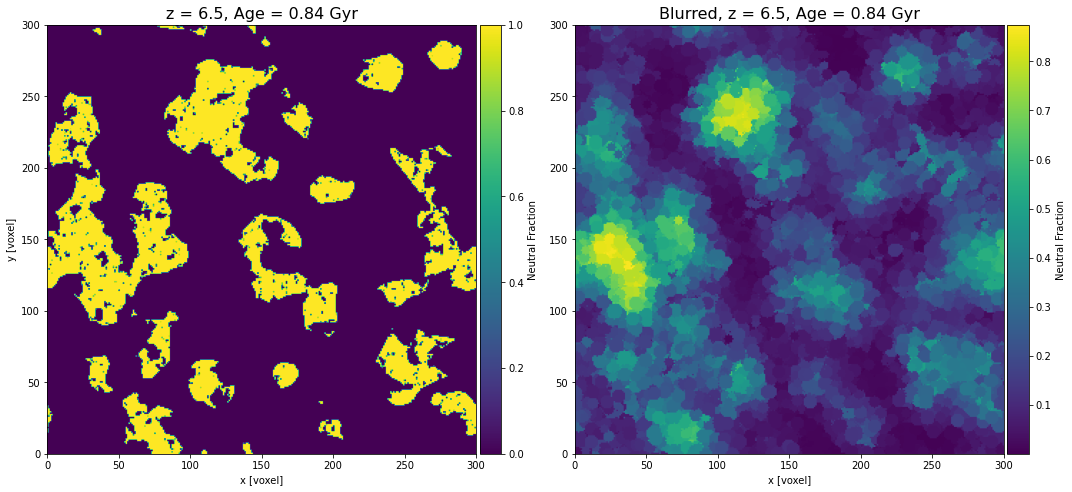

In [130]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Sphere_blurred[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)